In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

from dotenv import load_dotenv
import pandas as pd

# Import Utility Functions
from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.data.gcs_utils import GCSClient

from collab_env.alignment import reprojection, align

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load tracked data

In [192]:
data_type = 'fieldwork_processed'
session = '2024_02_06-session_0001'

session_data_dir = Path('/workspace/collab-environment/data/') / data_type / session
aligned_dir = session_data_dir / "aligned_frames" / "rgb_1"
mesh_dir = session_data_dir / "environment" / "C0043" / "rade-features" / "mesh"

mesh_fn = mesh_dir / "Open3dTSDFfusion_mesh.ply"

# Simulate bboxes for now
tracking_fn = aligned_dir / "rgb_1_tracked_bboxes.csv"

#"tracked_bboxes_1.csv"

df_tracks = pd.read_csv(tracking_fn)
df_tracks["track_id"] = df_tracks["track_id"].astype(int)
# df_filtered = df_tracks[df_tracks["track_id"] == 1]


#### Plot tracks over time

In [189]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

def visualize_frame_bounding_boxes(df: pd.DataFrame, frame_number: int):
    """
    Visualize all bounding boxes for a given frame.

    Args:
        df (pd.DataFrame): DataFrame with columns ['track_id', 'frame', 'x1', 'y1', 'x2', 'y2', 'confidence', 'class']
        frame_number (int): Frame number to visualize.
    """
    frame_df = df[df['frame'] == frame_number]

    if frame_df.empty:
        print(f"No bounding boxes found for frame {frame_number}.")
        return

    fig, ax = plt.subplots()
    ax.set_title(f"Bounding Boxes for Frame {frame_number}")

    # Auto set limits based on box sizes
    margin = 20
    x_min = frame_df[['x1', 'x2']].min().min() - margin
    x_max = frame_df[['x1', 'x2']].max().max() + margin
    y_min = frame_df[['y1', 'y2']].min().min() - margin
    y_max = frame_df[['y1', 'y2']].max().max() + margin

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_max, y_min)  # Keep origin at top-left like video/images
    
    for _, row in frame_df.iterrows():
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
        track_id = row['track_id']
        cls = row['class']
        conf = row['confidence']
        
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"ID: {track_id}, {cls} ({conf:.2f})", color='red', fontsize=8)

    plt.show()

#### Visualize bounding boxes

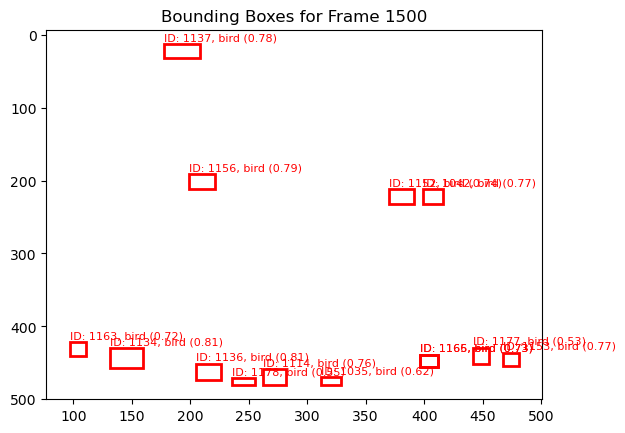

In [193]:
visualize_frame_bounding_boxes(df_tracks, frame_number=1500)

### Load camera parameters

In [446]:
import pickle

camera_params_fn = aligned_dir / "camera_params_mesh.pkl"

with open(camera_params_fn, 'rb') as f:
    camera_params = pickle.load(f)

camera = reprojection.Camera(
    K=camera_params['K'],
    c2w=camera_params['c2w'],
    width=camera_params['width'],
    height=camera_params['height']
)

In [447]:
mesh_environment = reprojection.MeshEnvironment(mesh_fn)

# Also updates camera.image and camera.depth --> stores them so no need to re-render
image, depth = mesh_environment.render_camera(camera)

[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x55dbf479e1f0 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


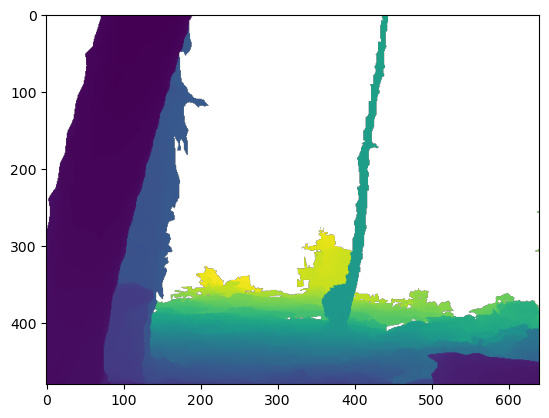

In [448]:
plt.imshow(camera.depth)

In [ ]:
def get_depths_in_bbox(depth_map, bbox):
    """
    Args:
        depth_map (np.ndarray): H x W array of depth values
        bbox (tuple): (x1, y1, x2, y2)
    
    Returns:
        np.ndarray: 2D array of depth values inside the bounding box
    """
    x1, y1, x2, y2 = map(int, bbox)
    return depth_map[y1:y2, x1:x2]

def get_bbox_pixel_indices(bbox, image_shape):
    """
    Get all (row, col) pixel indices inside a 2D bounding box.

    Args:
        bbox (tuple or list): Bounding box in (x1, y1, x2, y2) format (pixel coordinates).
        image_shape (tuple): (height, width) of the image to clamp indices.

    Returns:
        indices: (N, 2) array of (row, col) pixel indices within the bounding box.
    """
    x1, y1, x2, y2 = map(int, bbox)
    h, w = image_shape

    # Clamp to image boundaries
    x1 = np.clip(x1, 0, w - 1)
    x2 = np.clip(x2, 0, w - 1)
    y1 = np.clip(y1, 0, h - 1)
    y2 = np.clip(y2, 0, h - 1)

    # Generate grid of (row, col) indices
    rows = np.arange(y1, y2 + 1)
    cols = np.arange(x1, x2 + 1)
    rr, cc = np.meshgrid(rows, cols, indexing='ij')
    
    indices = np.stack([rr.ravel(), cc.ravel()], axis=1)  # shape (N, 2)
    
    return indices

In [491]:
bbox_indices = get_bbox_pixel_indices(bbox, camera.depth.shape)
bbox_indices_uv = bbox_indices[:, [1, 0]]  # swap columns to (u, v)

world_points = camera.project_to_world(bbox_indices_uv)

In [470]:
bbox = df_tracks.loc[100, ['x1', 'y1', 'x2', 'y2']].values.astype(float)

box_depth = get_depths_in_bbox(camera.depth, bbox)

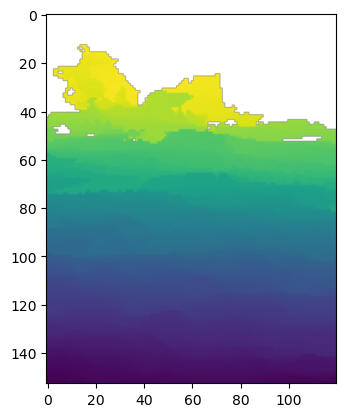

In [453]:
plt.imshow(box_depth)

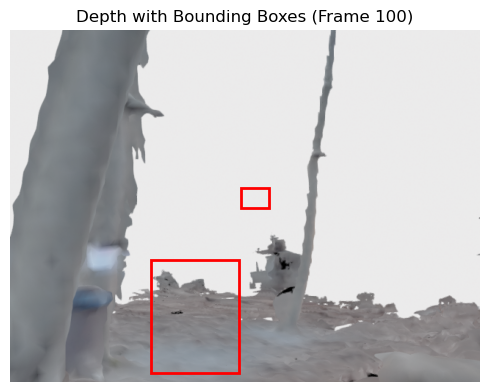

In [456]:
visualize_frame_bounding_boxes_on_depth(df_tracks, 100, camera.image)

In [239]:
import numpy as np

projected, depths = camera.project_to_camera(np.asarray(mesh_environment.mesh.vertices))

# camera.project_to_world(np.asarray(mesh.vertices), np.asarray(mesh.vertices))

In [240]:
bbox = df_tracks.loc[0, ['x1', 'y1', 'x2', 'y2']].values.astype(float)

# Step 1: Get which projected mesh points are inside the bbox
in_bbox_mask = filter_points_in_bbox(projected, *bbox)
projected_in_box = projected[in_bbox_mask]

# Step 2: Filter using visibility against the depth map
visible_idx_in_box = filter_visible(projected_in_box, depths, camera.depth)

# Step 3: Final 3D mesh points that are both in box and visible
visible_mesh_points = mesh_vertices[in_bbox_mask][visible_idx_in_box]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 248536 but corresponding boolean dimension is 11840

In [92]:
def filter_points_in_bbox(points_2d, x1, y1, x2, y2):
    """
    Filters 2D points to only those inside a bounding box.

    Args:
        points_2d: (N, 2) array of 2D pixel coordinates
        x1, y1, x2, y2: bounding box coordinates

    Returns:
        mask: (N,) boolean array indicating which points are inside the box
    """
    u, v = points_2d[:, 0], points_2d[:, 1]
    return (u >= x1) & (u <= x2) & (v >= y1) & (v <= y2)

def filter_visible(projected_2d, depths, depth_map, visibility_threshold=1e-2):
    """
    Filters projected points based on depth consistency with the depth buffer.

    Args:
        projected_2d: (N, 2) array of 2D pixel coordinates
        depths: (N,) depth values of 3D points
        depth_map: (H, W) depth image from rendering
        visibility_threshold: tolerance to consider a point visible

    Returns:
        indices: array of indices of visible points
    """
    u = np.round(projected_2d[:, 0]).astype(np.int32)
    v = np.round(projected_2d[:, 1]).astype(np.int32)

    # Validity mask
    valid = (u >= 0) & (u < depth_map.shape[1]) & (v >= 0) & (v < depth_map.shape[0])
    u_valid, v_valid = u[valid], v[valid]
    depths_valid = depths[valid]

    # Compare against depth buffer
    depth_buffer = depth_map[v_valid, u_valid]
    is_visible = np.abs(depths_valid - depth_buffer) < visibility_threshold

    return valid.nonzero()[0][is_visible]

In [425]:
# Filter by bounding box (e.g., first frame)
bbox = df_tracks.loc[0, ['x1', 'y1', 'x2', 'y2']].values.astype(np.float32)
in_bbox_mask = filter_points_in_bbox(projected, *bbox)

# Get 2D and depth for points inside bbox
projected_in_box = projected[in_bbox_mask]
depths_in_box = depths[in_bbox_mask]

# Visibility check
visible_idx_in_box = filter_visible(projected_in_box, depths_in_box, camera.depth)

# Final 3D points that are visible and inside bbox
points = np.asarray(mesh_environment.mesh.vertices)
visible_mesh_points = points[in_bbox_mask][visible_idx_in_box]

In [430]:
points.min(0)

array([-1.47068172, -0.26931728, -0.30781854])

In [431]:
visible_mesh_points.min(0)

array([-0.31980352,  0.55040349, -0.24624388])

In [42]:
def visualize_projection(camera, points3d):
    points2d = camera.project_to_camera(points3d)
    u, v = points2d[:, 0], points2d[:, 1]

    margin = 3  # pixels
    mask = (u >= margin) & (u < camera.width - margin) & (v >= margin) & (v < camera.height - margin)

    u_valid = np.round(u[mask]).astype(int)
    v_valid = np.round(v[mask]).astype(int)

    img = np.ones((camera.height, camera.width, 3), dtype=np.uint8) * 255

    img[v_valid, u_valid] = [255, 0, 0]

    plt.imshow(img)
    plt.axis('off')
    plt.title("Projection without edge effects")
    plt.show()


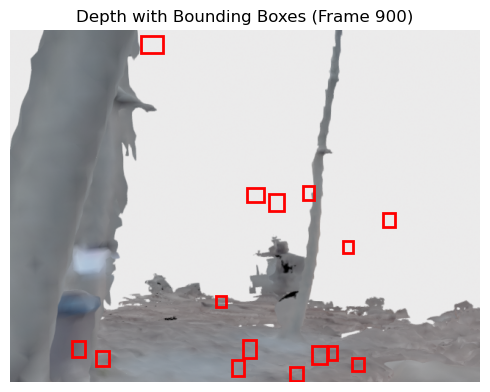

In [231]:
visualize_frame_bounding_boxes_on_depth(df_tracks, 900, camera.image)

In [208]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

def visualize_frame_bounding_boxes_on_depth(df: pd.DataFrame, frame_number: int, depth_image: np.ndarray):
    """
    Visualize bounding boxes for a specific frame over a depth image.

    Args:
        df (pd.DataFrame): DataFrame with columns ['track_id', 'frame', 'x1', 'y1', 'x2', 'y2', 'confidence', 'class']
        frame_number (int): Frame number to visualize.
        depth_image (np.ndarray): (H, W) depth map image.
    """
    frame_df = df[df['frame'] == frame_number]

    if frame_df.empty:
        print(f"No bounding boxes found for frame {frame_number}.")
        return

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.set_title(f"Depth with Bounding Boxes (Frame {frame_number})")

    # Normalize depth for display
    depth_display = np.nan_to_num(depth_image.copy())
    vmax = np.percentile(depth_display, 95)
    vmin = np.percentile(depth_display, 5)
    
    ax.imshow(depth_display, cmap='viridis', vmin=vmin, vmax=vmax)

    for _, row in frame_df.iterrows():
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
        track_id = row['track_id']
        cls = row['class']
        conf = row['confidence']
        
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        # ax.text(x1, y1 - 5, f"ID: {track_id}", color='red', fontsize=8)
        # ax.text(x1, y1 - 5, f"ID: {track_id}, {cls} ({conf:.2f})", color='white',
        #         fontsize=8, backgroundcolor='black')

    ax.axis('off')
    plt.tight_layout()
    plt.show()